# Assignment 1 - Part 3 - Code Submission for Andy Schreiner
## BIA 6303 - Predictive Models - Fall 2021
Note: main body of code was borrowed and adopted from Lectures of Rockhurst University BIA6303 - Instructor Nathaiel Bozarth 

In [1]:
import numpy as np
import pandas as pd

#url handler
from urllib.request import urlopen

#visualization libraries
from IPython.display import Image
import matplotlib.pyplot as plt
#specify that we want matplotlib to plot in this notebook
%matplotlib inline 
import seaborn as sns

#z scaler
from sklearn.preprocessing import StandardScaler

#models
from sklearn.feature_selection import *
from sklearn import linear_model
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn import svm

#data processing and validaiton
from sklearn.model_selection  import *
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#data
#from sklearn.datasets import fetch_california_housing

#use to read html
from bs4 import BeautifulSoup

### Load in the dataset from UCI

In [2]:
## AJS - this is the first time I have pulled data from the web like this. Pretty cool. As I ran into some issues with the 
##       import I worked through them one at a time. First off the header parameter was helpful to get the city value out of 
##       the header for column/feature 4 ("called 3"). The next item was using the separator parameter which it turns out I 
##       did not need. I understood that comma was the default but I tried using it with sep='\s*,\s*' to strip out blank spaces
##       which was a phantom problem. The real problem was that I did not know how to use the replace command. I now know that I
##       need to pass it to a df or use inplace=True. Finally I commented out the extra/unused pd.read_csv parameters (below)

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data", header=None)
#df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data", sep='\s*,\s*', header=None,na_values=["NaN"],encoding='latin-1',engine='python')

df.head()



,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


### Data cleansing

In [3]:
## AJS - as mentioned above this did not work as replace is not an 'inplace' function by default. See 
##       https://stackoverflow.com/questions/29247712/how-to-replace-a-value-in-pandas-with-nan for more info.
##       given the limited time left to understand the data or even label the features, I just imputed the median for the 
##       gaps in the dataset. This is not ethical in a real world scenario but it will pass for this exercise.

#df.replace('?', np.NaN)

df = df.replace('?', np.NaN)
df.fillna(df.median(),inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,23,48090,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,23,48090,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,0.08,0.03,0.75,0.5,0.00,0.15,0.67
2,24,23,48090,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,0.08,0.03,0.75,0.5,0.00,0.15,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,0.08,0.03,0.75,0.5,0.00,0.15,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,0.08,0.03,0.75,0.5,0.00,0.15,0.03


### Failed attempt to get feature names

In [4]:
## AJS - there are 128 names that I don't have the time or skill now to import into the dataset. The @attribute prefix could 
##       be used in a loop once I level up my Python skill. Currently I am just in the 'break all lockpicks' skill level. :-)
##       That is a RPG reference for fun.

communities_names = 'https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names'

## AJS - commenting the web call to clean up the output

# for line in urlopen(communities_names):
#     print(line.decode('utf-8'))

### Set the crime target variable as y

In [5]:
## AJS - I identified and isolated the target/outcome variable in a new dataframe 'y'. Then I removed it and the city
##       feature from the feature set 'x'

y = df.iloc[:,[127]]
x = df.drop(columns={3,127})
x.head()

,0,1,2,4,5,6,7,8,9,10,...,117,118,119,120,121,122,123,124,125,126
0,8,23,48090,1,0.19,0.33,0.02,0.90,0.12,0.17,...,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14
1,53,23,48090,1,0.00,0.16,0.12,0.74,0.45,0.07,...,0.26,0.02,0.12,0.45,0.08,0.03,0.75,0.5,0.00,0.15
2,24,23,48090,1,0.00,0.42,0.49,0.56,0.17,0.04,...,0.26,0.01,0.21,0.02,0.08,0.03,0.75,0.5,0.00,0.15
3,34,5,81440,1,0.04,0.77,1.00,0.08,0.12,0.10,...,0.26,0.02,0.39,0.28,0.08,0.03,0.75,0.5,0.00,0.15
4,42,95,6096,1,0.01,0.55,0.02,0.95,0.09,0.05,...,0.26,0.04,0.09,0.02,0.08,0.03,0.75,0.5,0.00,0.15


In [6]:
#AJS - quickly confirming y appears correctly

y.head()

,127
0,0.20
1,0.67
2,0.43
3,0.12
4,0.03


### SelectKBest feature review 

See documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

C:\Users\schre\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


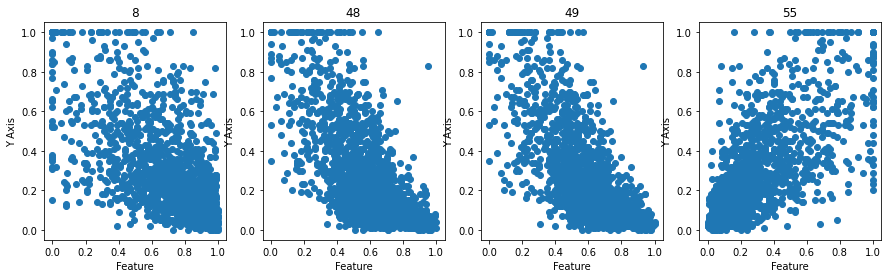

In [7]:

fs=SelectKBest(score_func=f_regression,k=4)
X_new=fs.fit_transform(x,y)

cols = fs.get_support(indices=True)
features_df_new = x.iloc[:,cols]


# Two subplots, unpack the axes array immediately
fig, axes = plt.subplots(1,4)
fig.set_size_inches(15,4)

for i in range(4):
    #axes[i].set_aspect('equal')
    axes[i].set_title(features_df_new.columns[i])
    axes[i].set_xlabel('Feature')
    axes[i].set_ylabel('Y Axis') #new high score on worst y axis label :-)
    plt.sca(axes[i])

    
    plt.scatter(X_new[:,i],y)


### Create a train and test sample of 75/25

In [8]:
## AJS - setting up the training and test set and setting the random state for repeatability

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=33)

In [9]:
## AJS - x is showing correctly with 1994*.75 = 1495
X_train.shape

(1495, 126)

In [10]:
y_train.shape

(1495, 1)

In [11]:
print(np.max(X_train), np.min(X_train), np.mean(X_train))

0      56.0
4      10.0
5       1.0
6       1.0
7       1.0
       ... 
100     1.0
118     1.0
119     1.0
120     1.0
125     1.0
Length: 101, dtype: float64 0      1.0
4      1.0
5      0.0
6      0.0
7      0.0
      ... 
100    0.0
118    0.0
119    0.0
120    0.0
125    0.0
Length: 101, dtype: float64 0      28.806689
4       5.505686
5       0.055472
6       0.467184
7       0.177806
         ...    
100     0.649612
118     0.064696
119     0.229278
120     0.159565
125     0.095625
Length: 101, dtype: float64


In [12]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [13]:
y_train = StandardScaler().fit_transform(y_train)
y_test = StandardScaler().fit_transform(y_test)

# Create in Scikit learn at least 4 of these GLMs:

In [14]:

def train_and_evaluate(clf, X_train, y_train):
    
    clf.fit(X_train, y_train)
    
    print("Coefficient of determination on training set:",clf.score(X_train, y_train))
    
    # create a k-fold croos validation iterator of k=5 folds
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print("Average coefficient of determination using 5-fold crossvalidation:",np.mean(scores))

In [15]:

clf_sgd = linear_model.SGDRegressor(loss='squared_loss', penalty=None,  random_state=42, shuffle=False)
print(clf_sgd)
train_and_evaluate(clf_sgd,X_train,y_train.ravel())
print(clf_sgd.coef_)

SGDRegressor(penalty=None, random_state=42, shuffle=False)
Coefficient of determination on training set: 0.7000564089097576
Average coefficient of determination using 5-fold crossvalidation: 0.6460841831133962
[-0.05736248 -0.05583773 -0.007563   -0.03180422 -0.0408452   0.03195116
  0.18002504 -0.06953991 -0.04467443  0.00680741  0.05068919 -0.12906635
 -0.01989028  0.01989003 -0.03209272  0.09098754  0.06504875 -0.08372248
  0.02931446 -0.04400343  0.06066     0.01431771 -0.08345837  0.1024392
 -0.03148594 -0.13530118 -0.02049182 -0.02003953  0.03418364  0.02924311
  0.02446404  0.00236084 -0.13189281 -0.03233528 -0.03183305  0.02267999
 -0.02970539  0.0873933  -0.05680811 -0.01333479  0.04802161  0.03145293
  0.09589992  0.06686018 -0.07512683 -0.00317656  0.00196828 -0.09517338
 -0.13948346 -0.03143779 -0.00116078 -0.0002674  -0.09719711 -0.05523598
  0.17481032 -0.02162516  0.0008593   0.00558979 -0.05234095  0.06019039
 -0.00092028  0.00394202  0.04822475  0.03896531 -0.02531181 

In [16]:
clf_sgd1 = linear_model.SGDRegressor(loss='squared_loss', penalty='l2',  random_state=42)
train_and_evaluate(clf_sgd1,X_train,y_train.ravel())

Coefficient of determination on training set: 0.7085678715668997
Average coefficient of determination using 5-fold crossvalidation: 0.6519058718932225


In [17]:
clf_sgd2 = linear_model.SGDRegressor(loss='squared_loss', penalty='l1',  random_state=42)
train_and_evaluate(clf_sgd2,X_train,y_train.ravel())

Coefficient of determination on training set: 0.6925553604127276
Average coefficient of determination using 5-fold crossvalidation: 0.6520175983148647


In [18]:
clf_sgd3 = linear_model.SGDRegressor(loss='squared_loss', penalty='elasticnet',  random_state=42)
train_and_evaluate(clf_sgd3,X_train,y_train.ravel())

Coefficient of determination on training set: 0.6907952359568902
Average coefficient of determination using 5-fold crossvalidation: 0.6519228466181277


# Ridge Regression - Model 1 


In [19]:
clf_ridge = linear_model.Ridge()
train_and_evaluate(clf_ridge,X_train,y_train)



Coefficient of determination on training set: 0.7241484444571848
Average coefficient of determination using 5-fold crossvalidation: 0.6519274687668923


In [20]:
## AJS - I had some fun with the cross validation outputs to make it clearer what they were saying, and added them for each model.

scores = cross_val_score(clf_ridge,X_train,y_train, cv=5)

print("RR Model 1")
print("")
print("Cross Validation Score for each fold")
print(scores)
print("")
print("Mean CV Score", scores.mean())  

RR Model 1

Cross Validation Score for each fold
[0.6384721  0.5942483  0.70045314 0.67482979 0.65163401]

Mean CV Score 0.6519274687668923


# Ridge Regression - Model 2

In [21]:
# Ridge Regression
import numpy as np
#from sklearn import datasets
from sklearn.linear_model import Ridge
# load the diabetes datasets
#dataset = datasets.load_diabetes()
# fit a ridge regression model to the data
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)
print(model)
# make predictions
expected = y_train
predicted = model.predict(X_train)
# summarize the fit of the model
mse = np.mean((predicted-expected)**2)
print(mse)
print(model.score(X_train, y_train))

Ridge(alpha=0.1)
0.27556662876262206
0.724433371237378


In [22]:
scores = cross_val_score(model,X_train,y_train, cv=5)
print(model)
print("")
print("Cross Validation Score for each fold")
print(scores)
print("")
print("Mean CV Score", scores.mean())  

Ridge(alpha=0.1)

Cross Validation Score for each fold
[0.63102936 0.59302712 0.69842648 0.67240507 0.64800664]

Mean CV Score 0.6485789330997935


# Lasso Regression - Model 3

In [23]:
# Lasso Regression
# fit a LASSO model to the data
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)
print(model)
# make predictions
expected = y_train
predicted = model.predict(X_train)
# summarize the fit of the model
mse = np.mean((predicted-expected)**2)
print(mse)
print(model.score(X_train, y_train))

Lasso(alpha=0.1)
1.4670042826607979
0.6320599380817272


In [24]:
scores = cross_val_score(model,X_train,y_train, cv=5)
print(model)
print("")
print("Cross Validation Score for each fold")
print(scores)
print("")
print("Mean CV Score", scores.mean())  

Lasso(alpha=0.1)

Cross Validation Score for each fold
[0.59665825 0.5873928  0.66967909 0.64721832 0.61513323]

Mean CV Score 0.6232163360760017


# ElasticNet Regression - Model 4

In [25]:
# ElasticNet Regression
# fit a model to the data
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=0.1)
model.fit(X_train, y_train)
print(model)
# make predictions
expected = y_train
predicted = model.predict(X_train)
# summarize the fit of the model
mse = np.mean((predicted-expected)**2)
print(mse)
print(model.score(X_train, y_train))

ElasticNet(alpha=0.1)
1.5463589531310817
0.6617533290756865


In [26]:
scores = cross_val_score(model,X_train,y_train, cv=5)
print(model)
print("")
print("Cross Validation Score for each fold")
print(scores)
print("")
print("Mean CV Score", scores.mean())   

ElasticNet(alpha=0.1)

Cross Validation Score for each fold
[0.62467899 0.60108409 0.69904849 0.66925026 0.64656386]

Mean CV Score 0.6481251375411556


# Model Performance Summary

In [27]:
## AJS - I found that the Ridge Regression Model 2 performed better than Lasso or ElasticNet on this dataset. The Mean Squared 
##      Error was markedly lower in the model 2 (.276) compared to the other two models (1.467 & 1.546 respectively). 

## SVR
In the docs, sklearn does not recommend using with "more than a couple of 10000 samples". They recommend using LinearSVR or SGDRegressor instead.

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [28]:

%%time
#This takes a really long time! 
clf_svr_grid = GridSearchCV(estimator=svm.SVR(),
             param_grid={'C': [1, 5, 10], 'kernel': ('linear', 'poly', 'rbf')})

clf_svr_grid.fit(X_train,y_train.ravel())

Wall time: 3min 2s


GridSearchCV(estimator=SVR(),
             param_grid={'C': [1, 5, 10], 'kernel': ('linear', 'poly', 'rbf')})

In [29]:
clf_svr_grid.cv_results_

{'mean_fit_time': array([ 2.0144352 ,  0.11470437,  0.12551394, 10.55510254,  0.13632236,
         0.15093699, 22.24632115,  0.15053706,  0.16998711]),
 'std_fit_time': array([1.66234942e-01, 1.62619250e-03, 2.06096832e-03, 1.57811492e+00,
        1.94017335e-03, 2.31721162e-03, 4.66479210e+00, 1.35745039e-03,
        4.35695990e-03]),
 'mean_score_time': array([0.0192174 , 0.02081895, 0.02482266, 0.01945643, 0.02121897,
        0.0254231 , 0.01901708, 0.02121921, 0.02542472]),
 'std_score_time': array([4.00352506e-04, 4.00424014e-04, 4.00280992e-04, 4.64383613e-04,
        4.00448300e-04, 4.90427038e-04, 3.87384339e-07, 4.00209612e-04,
        4.88921743e-04]),
 'param_C': masked_array(data=[1, 1, 1, 5, 5, 5, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear', 'poly', 'rbf', 'linear', 'poly', 'rbf',
                    'line

In [30]:
clf_svr_grid.best_params_

{'C': 1, 'kernel': 'linear'}

In [31]:
clf_svr_best = svm.SVR(kernel='rbf', C=10)
train_and_evaluate(clf_svr_best, X_train,y_train.ravel())

Coefficient of determination on training set: 0.9601112162997233
Average coefficient of determination using 5-fold crossvalidation: 0.5994431355318272


In [32]:
clf_svr_poly2= svm.SVR(kernel='poly',degree=2)
train_and_evaluate(clf_svr_poly2,X_train,y_train.ravel())

Coefficient of determination on training set: 0.7277667141718954
Average coefficient of determination using 5-fold crossvalidation: 0.41668395322574014
